# Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# !unzip /content/drive/MyDrive/Senior/Spring/EC523/FinalProject/ec523/data.zip
#!unzip /content/drive/MyDrive/School/Graduate/Classes/2024\ Spring/EC523\ Deep\ Learning/data.zip

!unzip /content/drive/MyDrive/ec523/data.zip

Archive:  /content/drive/MyDrive/ec523/data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/annotations/
   creating: data/videos/
  inflating: data/annotations/.DS_Store  
   creating: data/annotations/s1/
  inflating: data/videos/prwq3s.mpg  
  inflating: data/videos/pbib8p.mpg  
  inflating: data/videos/lrae3s.mpg  
  inflating: data/videos/pgid6p.mpg  
  inflating: data/videos/pbao8n.mpg  
  inflating: data/videos/prbx3s.mpg  
  inflating: data/videos/lbbk6p.mpg  
  inflating: data/videos/bgwu6n.mpg  
  inflating: data/videos/sbig6p.mpg  
  inflating: data/videos/pgby5s.mpg  
  inflating: data/videos/bras8p.mpg  
  inflating: data/videos/sgiczp.mpg  
  inflating: data/videos/lrwl7a.mpg  
  inflating: data/videos/bbbz8n.mpg  
  inflating: data/videos/bram3s.mpg  
  inflating: data/videos/pwwk7a.mpg  
  inflating: data/videos/bbws8n.mpg  
  inflating: data/videos/brbtzn.mpg  
  inflating: data/videos/bwwbzp.mpg  
  inflating: data/videos/lrbr5s.mpg  
  

# Data Pre-Processing (Haar classifier, normalization, etc.)

In [47]:
import os

import cv2
import tensorflow as tf

# Unique syllable tokens in LipNet dataset
tokens = ['a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e', 'eight',
          'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j', 'k', 'l',
          'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p', 'place', 'please',
          'q', 'r', 'red', 's', 'set', 'seven', 'sil', 'six', 'soon', 'sp', 't',
          'three', 'two', 'u', 'v', 'white', 'with', 'x', 'y', 'z', 'zero']


def process_video_file(path: str):
    """
    Images are now fully pre-processed here before being stored or saved.
    """

    # Load video
    cap = cv2.VideoCapture(path)  # e.g. /content/data/videos/bbaf2n.mpg

    frame_count = 0
    # processed_frames = []
    tensors_list = []

    while True:

        # Read frame from vid
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grey scale
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = frame  # TODO: Temporarily testing with color images

        # Lip detection
        for x in reversed(range(5, 8)):  # lower conditions as needed to find best match
            lips = lip_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=x, minSize=(60, 30), maxSize=(120, 60))
            if len(lips) > 0:
                break
        if len(lips) == 0:  # if still no match, use static vals
            lips = [[50, 150, 200, 100]]
        (x, y, w, h) = lips[0]
        # print(f'{frame_count:02d}', ': ', lips[0])

        # Store normalized, grayscaled, and uniformly cropped
        gray_normal_crop = cv2.normalize(gray, gray, 0, 100, cv2.NORM_MINMAX)[y:y+h, x:x+w]
        final_img = cv2.resize(gray_normal_crop, (80, 40))
        tensors_list.append(final_img)

        # Save to file
        # cv2.imwrite(os.path.join(output_dir, f'frame_{frame_count}.jpg'), final_img)

        # Save some of the color images with the bounding box...
        # if frame_count == 10:
        #     cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 200, 0), 2)  # draws rectangle
        #     cv2.imwrite(os.path.join(output_dir, f'frame_{frame_count}.jpg'), frame)

        frame_count += 1

    # TODO: tf.normalize across all images?
    # mean = tf.math.reduce_mean(processed_frames)
    # std = tf.math.reduce_std(tf.cast(processed_frames, tf.float32))
    # processed_frames.append(cv2.normalize(gray, gray, 0, 100, cv2.NORM_MINMAX)[y:y+h, x:x+w])
    # processed_frames = (tf.cast((processed_frames - mean), tf.float32) / std).numpy()
    # for i, v in enumerate(processed_frames):
    #     output_path = os.path.join(output_dir, f"frame_{i}.jpg")
    #     cv2.imwrite(output_path, v)
    # print(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))  # number of frames in video

    cap.release()

    # print(f"Finished processing video; {frame_count} frames saved in:", output_dir)
    # print(f'\nvideo_tensor ({type(video_tensor)}, {video_tensor.shape}): \n', video_tensor)

    return np.array(tensors_list)


# Load annotations
def load_annotations(annotation_file: str) -> list[str]:

    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        annotations = [line.strip().split() for line in lines]

    return annotations


def process_annotations_file(path: str):
    """
    Should experiment with syllable labels vs. video labels...
    """

    # annotation_file = "/content/data/annotations/s1/bbaf2n.align"
    annotations = load_annotations(path)

    # Map frames to annotations based on filename; each annotation line contains:
    # [<start of syllable to thousandth of a frame>,
    #    <end of syllable to thousandth of a frame>,
    #    <syllable/annotation>]
    # frame_labels = []
    video_label = ''
    for line in annotations:
        # rng = np.array([int(line[0]), int(line[1])]) // 1000
        # frame_labels[rng[0]:rng[1] + 1] = [line[2]] * ((rng[1] + 1) - rng[0])

        # for letter in line[2]:
        #     video_label.append(ord(letter) - 97)

        token = line[2]
        # video_label.append(next(i for i, v in enumerate(tokens) if v == token))
        video_label += token

    # print(f'\nannotated_frames ({(cnt := len(frame_labels))}): \n', frame_labels)
    # print(f'\nvideo_label ({len(video_label)}, {type(video_label)}): \n', video_label)

    # Tests (for bbaf2n)
    # assert cnt == frame_count
    # assert frame_labels[33] == 'blue' and frame_labels[34]      == 'at'
    # assert frame_labels[0]  == 'sil'  and frame_labels[cnt - 1] == 'sil'
    # assert video_label[0]   == 18     and video_label[3]        == 1

    # TODO: Remove 'sil' (i.e. silence) frames?

    return video_label


In [52]:
import os
import numpy as np
import cv2
import tensorflow as tf

# Directory to store processed frames
output_dir = "/content/processed_frames"
os.makedirs(output_dir, exist_ok=True)

# Directories for videos and annotations
videos_dir = '/content/data/videos'
annotations_dir = '/content/data/annotations/s1'

# Set limit to 0 to remove limit and use all videos
video_limit = 15  # On Google Colab Pro, 100 takes about ~6 mins to load, also for some reason when you go above 19 it gives an error about inhomogenous shape

# Use Haar cascade for lip detection
lip_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Loop over files, loading images and labels
inputs = []
labels = []
for i, annotations_name in enumerate(os.listdir(annotations_dir)):
    if i > video_limit and video_limit > 0:
        break
    name = annotations_name.split('.')[0]

    # TODO: Best to treat video label as a single categorical label, or label by syllable?
    labels.append(len(labels))
    # labels.append(process_annotations_file(f'{annotations_dir}/{annotations_name}'))

    input = process_video_file(f'{videos_dir}/{name}.mpg')
    inputs.append(input)

    print(i, ': ', name, input.shape)

inputs = np.array(inputs)
labels = np.array(labels)

print(f'\ninputs ({inputs.shape}): \n')#, inputs)
print(f'\nlabels ({labels.shape}): \n')#, labels)


0 :  prii9a (75, 40, 80, 3)
1 :  bwwa9s (75, 40, 80, 3)
2 :  lgbf9s (75, 40, 80, 3)
3 :  pbbp5a (75, 40, 80, 3)
4 :  pgbr2p (75, 40, 80, 3)
5 :  prwd4n (75, 40, 80, 3)
6 :  lrbe6n (75, 40, 80, 3)
7 :  lwafzp (75, 40, 80, 3)
8 :  lbay1a (75, 40, 80, 3)
9 :  brbg5a (75, 40, 80, 3)
10 :  pwij5a (75, 40, 80, 3)
11 :  srau3s (75, 40, 80, 3)
12 :  sbat6n (75, 40, 80, 3)
13 :  pripzn (75, 40, 80, 3)
14 :  pgwy8n (75, 40, 80, 3)
15 :  sgav5s (75, 40, 80, 3)
16 :  lrae3s (74, 40, 80, 3)
17 :  lbbrzp (75, 40, 80, 3)
18 :  bram3s (75, 40, 80, 3)
19 :  briz9a (75, 40, 80, 3)
20 :  lbid3s (75, 40, 80, 3)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21,) + inhomogeneous part.

# Model Creation

In [49]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, labels, test_size=0.2, random_state=42)

print(f'\nX_train {X_train.shape}: \n')#, X_train)
print(f'\nX_val   {X_val.shape}:   \n')#, X_val)
print(f'\ny_train {y_train.shape}: \n')#, y_train)
print(f'\ny_val   {y_val.shape}:   \n')#, y_val)



X_train (12, 75, 40, 80, 3): 


X_val   (4, 75, 40, 80, 3):   


y_train (12,): 


y_val   (4,):   



In [50]:
"""
TODO: Need to experiment with different kernel size, adding dropout, regularization, etc.

Document clearly; such testing can be a part of the final submission.

"""

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, constraints
from keras.utils import to_categorical
from tensorflow.python.keras.layers import Dropout

# Define width, height, and number of frames
width      = 80  # originally 224
height     = 40  # originally 224
num_frames = 75  # Number of frames per video (currently using all frames)
channels   = 3

# Calculate the number of unique classes or labels
num_classes = len(labels)

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded   = to_categorical(y_val,   num_classes)

# Define the lip reading model architecture
model = models.Sequential([
    # 3D Convolutional layers
    layers.Conv3D(32,   (3, 3, 3), activation='relu', padding='same', input_shape=(num_frames, height, width, channels)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Dropout(0.2), #visible layer dropout regularization
    layers.Conv3D(64,   (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(128,  (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((1, 2, 2)),  # Adjusted pooling size

    # Flatten layer
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'), #if we use dropout it might be good to have a  kernel constraint here: layers.Dense(128, activation='relu', kernel_constraint=MaxNorm(variable))
    #layers.Dropout(0.6), #hidden layer dropout regularization
    layers.Dense(num_classes, activation='softmax')
])
'''
For the model architecture, dropout can be applied to the visible layer but will require a probability of retention closer to 1
so idealy set the visible dropout to p=0.2, but if dropout is applied between hidden layers then it is better to use 0.4<p<0.8
P is a tunable hyperparameter but finding the ideal value for our model would likely take several more hours of training so I just kept it
constant for now.
It is possible that we can also use gaussian dropout with a probability vector p = (p1,p2,...pn) and variance ((1-p)/p)^0.5 which a couple of research
papers recommend to further improve accuracy but it is a lot more complicated and time consuming
An interesting and annoying error is that keras won't allow for the dropout layer to be applied to the visible layer for some reason, most likely due to
something internal about the Sequential model class.
'''
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 75, 40, 80, 32)    2624      
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 37, 20, 40, 32)    0         
 ng3D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 37, 20, 40, 32)    0         
                                                                 
 conv3d_40 (Conv3D)          (None, 37, 20, 40, 64)    55360     
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 18, 10, 20, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_41 (Conv3D)          (None, 18, 10, 20, 128) 

# Model Training and Testing

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 23.8559 - accuracy: 0.0833 - val_loss: 934.5184 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 289ms/step - loss: 1673.0669 - accuracy: 0.0000e+00 - val_loss: 483.6898 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 241ms/step - loss: 574.4266 - accuracy: 0.0833 - val_loss: 125.5522 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 190ms/step - loss: 89.5152 - accuracy: 0.0833 - val_loss: 30.0968 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 192ms/step - loss: 7.2374 - accuracy: 0.0833 - val_loss: 28.2688 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 228ms/step - loss: 24.7737 - accuracy: 0.0833 - val_loss: 14.6880 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 192ms/step - loss: 12.8805 - accuracy: 0.0833 - val_loss: 11.0636 - v

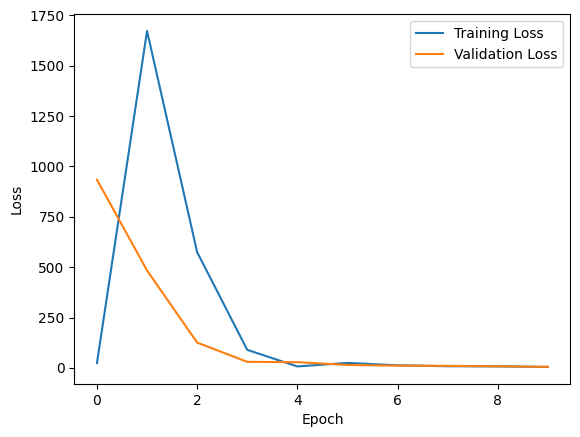

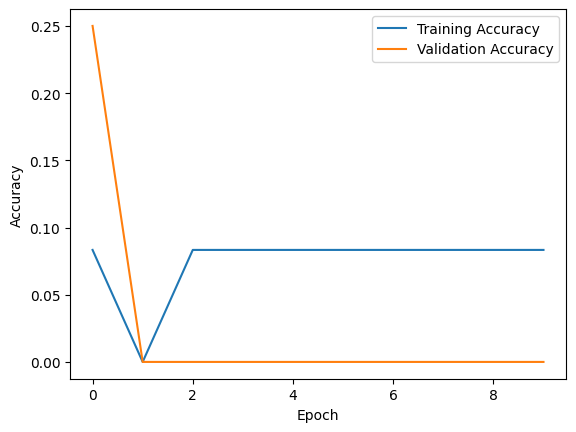

In [51]:
"""
TODO: Experiment with fine-tuning batch_size, etc.

Document clearly; such testing can be a part of the final submission.

"""

import matplotlib.pyplot as plt

# train model using your processed frames as input data
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=15, validation_data=(X_val, y_val_encoded))

# model performance
loss, accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# TODO: Option to print actual model estimate (syllable sequence for that video)


In [ ]:
# TODO: Implement...

%load_ext tensorboard
%tensorboard --logdir logs

import visualkeras

visualkeras.layered_view(model).show()

# Old Cells

In [ ]:
"""
Now being handled above; kept cell for future reference
"""

import os

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical

# Generate list of unique tokens (i.e. syllables)
# temp_labels = []
# for i, annotations_name in enumerate(os.listdir(annotations_dir)):
#     if annotations_name.endswith('.align'):
#         annotations = load_annotations(f'{annotations_dir}/{annotations_name}')
#         for line in annotations:
#             if line[2] not in temp_labels:
#                 temp_labels.append(line[2])
# print(sorted(temp_labels))


# extract label from filename
def extract_label(filename):
    label = filename.split("_")[1].split(".")[0]  # labels are now defined above
    return label


# Function to load and preprocess frames
# (Now being handled above, before the images are saved, to reduce space)
def load_and_preprocess_frames(directory):
    frames = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # load the frame
            img = cv2.imread(os.path.join(directory, filename))
            # preprocess frame (resize, normalize, etc.)
            img = cv2.resize(img, (width, height))  # resize frame
            img = img / 255.0  # normalize pixel values to [0, 1]
            # append the frame and label
            frames.append(img)
            labels.append(extract_label(filename))  # extract label

    return np.array(labels)#, np.array(frames)


# Load and preprocess frames
# labels = load_and_preprocess_frames("/content/processed_frames")
# print(labels)
